### Analysis of Northeast Indian + Nepali samples to delineate migration patterns in the Himalayan region

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import numpy as np
from datetime import date
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
from copy import deepcopy
import itertools as it
import statsmodels.api as sm
from scipy.stats.distributions import chi2
from random import choices
import scipy as sp
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import haversine_distances

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import seaborn as sns
import plotly.express as px
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# feems
import sys
sys.path.append('../../')
from feems.utils import prepare_graph_inputs
from feems.spatial_graph import query_node_attributes
from feems import SpatialGraph, Viz, Objective
from feems.cross_validation import run_cv, comp_mats, run_cv_joint
from feems.helper_funcs import cov_to_dist, comp_genetic_vs_fitted_distance, plot_default_vs_long_range, get_best_lre
from feems.joint_ver import FEEMSmix_SpatialGraph, FEEMSmix_Objective

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["axes.axisbelow"] = True

In [212]:
# os.chdir("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/NEI/data")
# (bim, fam, G) = read_plink("FEEMS_v2_noEA_pruned")

## need to create a .coord file with # of rows = # of samples and 2 columns (Longitude, Latitude)
# poplocs = pd.read_csv('poplist_FEEMS_v3.csv')
# indlocs = np.zeros((fam.shape[0],2))
# for i in range(fam.shape[0]):
#     indlocs[i,:] = poplocs.loc[poplocs['Location'] == fam['fid'][i], ['Lon', 'Lat']]
# np.savetxt('indlist.coords', indlocs, delimiter='\t')
# coord = np.loadtxt("indlist.coords")
# coord = np.loadtxt("indlist_noEA.coords")
# outer = np.loadtxt("outer.coords")
# grid_path = "/Users/vivaswatshastry/src/feems/feems/data/grid_50.shp"
# grid_path = "/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/59-Ursus_Example/world_triangle_res8.shp"

# np.savetxt('indlist_noEA.coords', indlocs[np.where(~fam['fid'].isin(['Japanese','CHB','Korean']))[0]], delimiter='\t')

outer, edges, grid, _ = prepare_graph_inputs(coord=indlocs, 
                                             ggrid=grid_path,
                                             translated=False, 
                                             buffer=1,
                                             outer=None)

Mapping files:   0%|          | 0/3 [01:06<?, ?it/s]
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


In [213]:
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)
genotypes = np.delete(genotypes,np.where(genotypes.sum(axis=0)==2*genotypes.shape[0])[0],1)
genotypes = np.delete(genotypes,np.where(genotypes.sum(axis=0)==0)[0],1)

# print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))
## subsampling to 50k SNPs for initial run
# genotypes_sub = genotypes[:,np.random.choice(np.arange(genotypes.shape[1]),50000,replace=False)]
# genotypes_sub = np.delete(genotypes_sub,np.where(genotypes_sub.sum(axis=0)==0)[0],1)
# genotypes_sub = np.delete(genotypes_sub,np.where(genotypes_sub.sum(axis=0)==2*genotypes_sub.shape[0])[0],1)

# genotypes_sub2 = genotypes[:,np.random.choice(np.arange(genotypes.shape[1]),200000,replace=False)]
# genotypes_sub2 = np.delete(genotypes_sub2,np.where(genotypes_sub2.sum(axis=0)==0)[0],1)
# genotypes_sub2 = np.delete(genotypes_sub2,np.where(genotypes_sub2.sum(axis=0)==2*genotypes_sub2.shape[0])[0],1)

array([  1.        ,   3.16227766,  10.        ,  31.6227766 ,
       100.        ])

In [176]:
# spgraph = SpatialGraph(genotypes, indlocs, grid, edges)
# %time spgraph.fit(lamb=400.)
 
# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, spgraph, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5, obs_node_size=1.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
# v.draw_map(latlong=[[20,25,30,35],[70,80,90,100]]); v.draw_samples(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()

In [231]:
# sp_graph = FEEMSmix_SpatialGraph(genotypes, indlocs, grid, edges)
%time sp_graph.fit(lamb=1., optimize_q='n-dim')
obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

# projection = ccrs.AzimuthalEquidistant(central_longitude=90, central_latitude=23)   
# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, sp_graph, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5, obs_node_size=1.5, sample_pt_color="black", cbar_ticklabelsize=10, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8, abs_max=2)
# v.draw_map(latlong=[[20,25,30,35],[70,80,90,100]])
# v.draw_samples(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
## plt.savefig('../results/noEA_ndim_lamb30.pdf', bbox_inches='tight')
# v.ax.add_feature(cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',
#     scale='110m', facecolor='none', edgecolor='grey'))
# obs_grid = v.grid[query_node_attributes(sp_graph, "permuted_idx")[: sp_graph.n_observed_nodes],:]
# colshigh = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']
# colslow = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0']
# dash = ['-', '--', '-.', ':', 'solid']
# for ij, j in enumerate(np.unique(np.array(max_res_node)[:,1])):
#     for i in np.where(np.array(max_res_node)[:,1]==j)[0]:
#         v.ax.plot(
#             [obs_grid[max_res_node[i][0], 0],obs_grid[max_res_node[i][1],0]],
#             [obs_grid[max_res_node[i][0], 1],obs_grid[max_res_node[i][1],1]],
#             color = colslow[ij], linewidth = 1, alpha=0.95, ls=dash[ij] 
#         )
    # v.ax.text(
    #     np.mean([obs_grid[max_res_[i][0], 0],obs_grid[pair[i][1], 0]]),
    #     np.mean([obs_grid[pair[i][0], 1],obs_grid[pair[i][1], 1]]),
    #     str("{:.3f}".format(pval[i])),
    #     horizontalalignment="left",
    #     verticalalignment="center",
    #     size=v.obs_node_textsize*1.1
    # )
# for ie, e in enumerate([(24, 28),(33, 30),(30,31)]):
#         v.draw_arrow([e],1.,lw=2.2,hw=.5e5,hl=1e5,mode='sampled')

constant-w/variance fit, converged in 138 iterations, train_loss=-1996635.202
lambda=1.000, alpha=0.3350, converged in 5296 iterations, train_loss=-3382173.359
CPU times: user 36min 33s, sys: 29min 54s, total: 1h 6min 28s
Wall time: 16min 9s


In [219]:
np.min(v.norm_log_weights)

-3.333663464467007

Text(0, 0.5, 'genetic distance')

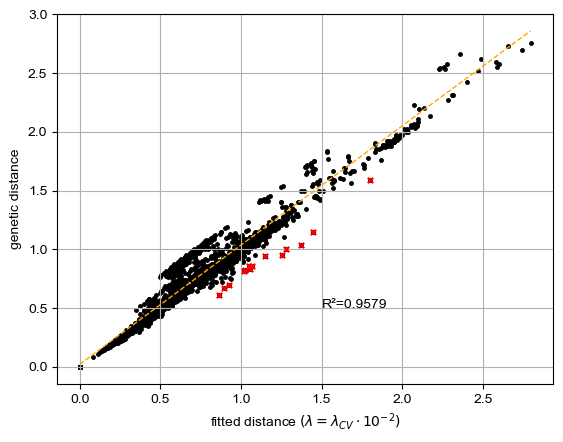

In [232]:
fit_cov, _, emp_cov = comp_mats(obj); tril_idx = np.tril_indices(sp_graph.n_observed_nodes)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
plt.scatter(fit_dist, emp_dist, marker=".", alpha=1, zorder=0, color="black", s=25)
plt.scatter(fit_dist[res.resid<-0.23],emp_dist[res.resid<-0.23],marker='x',color='red',s=15)
x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
plt.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1); plt.grid()
plt.text(1.5, .5, "R²={:.4f}".format(res.rsquared), size='x-large')
plt.xlabel("fitted distance $(\lambda = \lambda_{CV} \cdot 10^{-2})$")
plt.ylabel("genetic distance")

## finding variants that have positive residuals
# plt.hist(res.resid,15)
# max_res_node = []
# for k in np.where(res.resid<-0.3)[0]:
#     x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1
#     y = int(k - 0.5*x*(x-1))
#     max_res_node.append(sorted((x,y)))
# lrn_idx = [int(val[0] + 0.5*val[1]*(val[1]+1) - val[1]) if val[0]<val[1] else int(val[1] + 0.5*val[0]*(val[0]+1) - val[0]) for val in max_res_node]

In [236]:
# sp.stats.norm.cdf(-0.3,0,np.std(res.resid))

In [ ]:
lamb_grid = np.geomspace(1e0, 1e3, 12)[::-1]
cv_err = run_cv(sp_graph, lamb_grid, n_folds=5, factr=1e10)
mean_cv_err = np.mean(cv_err, axis=0)
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])

plt.plot(lamb_grid,mean_cv_err,'bo'); plt.axvline(float(lamb_grid[np.argmin(mean_cv_err)]),color='orange'); plt.semilogx(); plt.xlabel(r'$\lambda$'); plt.ylabel('CV error'); plt.grid()

In [ ]:
# from matplotlib import gridspec
fig = plt.figure(constrained_layout=True, dpi=300, figsize=(6, 6))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

# (A) Genetic distance vs geographic distance
# D_geno = squareform(pdist(sp_graph.genotypes, metric="sqeuclidean")) / sp_graph.n_snps
coord_rad = indlocs[:,::-1] * np.math.pi / 180.0
D_geo = haversine_distances(coord_rad) * 6371000/1000
tril_idx = np.tril_indices(sp_graph.genotypes.shape[0], k=-1)
x = D_geo[tril_idx]
y = D_geno[tril_idx]
X = sm.add_constant(x)
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params

ax_00 = fig.add_subplot(spec[0, 0])
ax_00.set_title("A", loc='left')
ax_00.scatter(x, 
              y, 
              marker=".", 
              alpha=1, 
              zorder=0, 
              color="black",
              s=3)

x_ = np.linspace(np.min(x), np.max(x), 20)
ax_00.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1); ax_00.grid()
ax_00.text(1500, .3, "R²={:.4f}".format(res.rsquared))
ax_00.set_xlabel("great circle distance (km)")
ax_00.set_ylabel("genetic distance")

# (B) Genetic distance vs fitted distance for constant w model 
tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)
ax_01 = fig.add_subplot(spec[0, 1])
ax_01.set_title("B", loc='left')
sp_graph.fit_null_model()
sp_graph.comp_graph_laplacian(sp_graph.w)

obj = FEEMSmix_Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
ax_01.scatter(fit_dist, 
              emp_dist, 
              marker=".", 
              alpha=1, 
              zorder=0, 
              color="black",
              s=3)

x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
ax_01.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1); ax_01.grid()
ax_01.text(2, 0.5, "R²={:.4f}".format(res.rsquared))
ax_01.set_xlabel("fitted distance (constant w)")

# (C) Genetic distance vs fitted distance for lambda = lambda_cv
tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)
ax_10 = fig.add_subplot(spec[1, 0])
ax_10.set_title("C", loc='left')
lamb = lamb_cv
sp_graph.fit(lamb=lamb,
             lb=np.math.log(1e-6), 
             ub=np.math.log(1e+6))
sp_graph.comp_graph_laplacian(sp_graph.w)

obj = FEEMSmix_Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
ax_10.scatter(fit_dist,
              emp_dist,
              marker=".", 
              alpha=1, 
              zorder=0, 
              color="black",
              s=3)

x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
ax_10.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1); ax_10.grid()
ax_10.text(2., 0.5, "R²={:.4f}".format(res.rsquared))
ax_10.set_xlabel("fitted distance $(\lambda = \lambda_{CV} = 359)$")
ax_10.set_ylabel("genetic distance")

# (D) Genetic distance vs fitted distance for lambda = 1e-3*lambda_cv
ax_11 = fig.add_subplot(spec[1, 1])
ax_11.set_title("D", loc='left')
lamb = 0.001*lamb_cv
sp_graph.fit(lamb=lamb,
             lb=np.math.log(1e-6), 
             ub=np.math.log(1e+6))
sp_graph.comp_graph_laplacian(sp_graph.w)

obj = FEEMSmix_Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
ax_11.scatter(fit_dist,
              emp_dist,
              marker=".", 
              alpha=1, 
              zorder=0, 
              color="black",
              s=3)

x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
ax_11.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1); ax_11.grid()
ax_11.text(2., 0.5, "R²={:.4f}".format(res.rsquared))
ax_11.set_xlabel("fitted distance ($\lambda = \lambda_{CV}\cdot 10^{-3}$)")
ax_11.set_ylabel("genetic distance")